<a href="https://colab.research.google.com/github/jlifferth/UQ-BIO-2022/blob/main/Module_3_2_Stochastic_Simulation_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
Learning Assistant: Joshua Cook
Authors: Lisa Weber, Joshua Cook, Brian Munsky
Contact Info: jcook10@rams.colostate.edu
 
Copyright (c) 2021, 2022 Dr. Brian Munsky. 
Dr. Luis Aguilera, Will Raymond
Colorado State University.
Licensed under MIT License.
```
Disclaimer: The codes provided here are not optimized for speed and/or efficiency, and are not intended to be used in research. These python codes are specifically designed to enhance understanding of python and the algorithms being discussed. 

----------
## Learning Objectives for this Notebook:
--------------

After completing this notebook, students should:
* Be familiar with stochasticity and examples of stochasticity in biological systems.
* Be able to identify and set up stochiometery vectors and propensity functions for biological models.
* Be able to set up and use the stochastic simmulation algorithm
* Understand how reaction constants affect SSA trajectories
* Use stochastic simulations to create distributions for at specific time points for a model

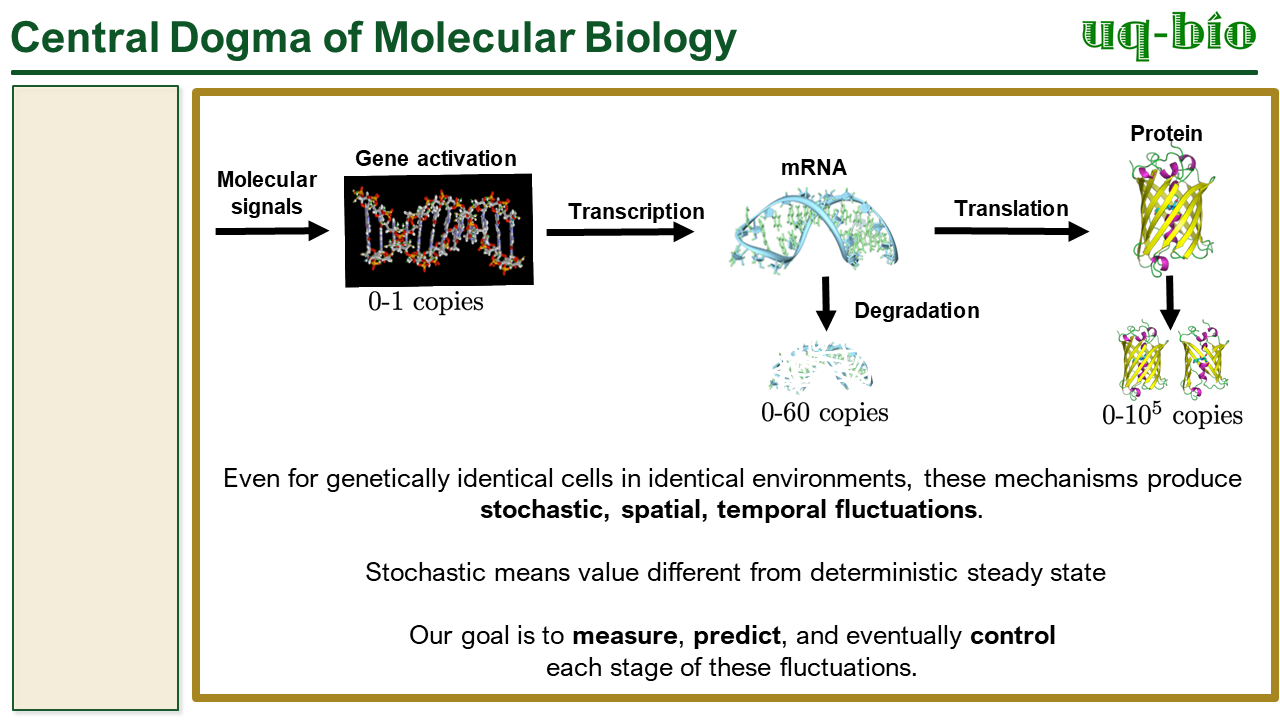

**Question:**
Rank the following in order of least to most variation relative to the mean expected behavior (i.e., lowest to highest Fano factor).
*  the number of active genes in a cell, 
*  the number of mRNA in a cell, 
*  the number of mature protein in a cell. 

  * (Space to answer all questions are given at the end of the notebook)

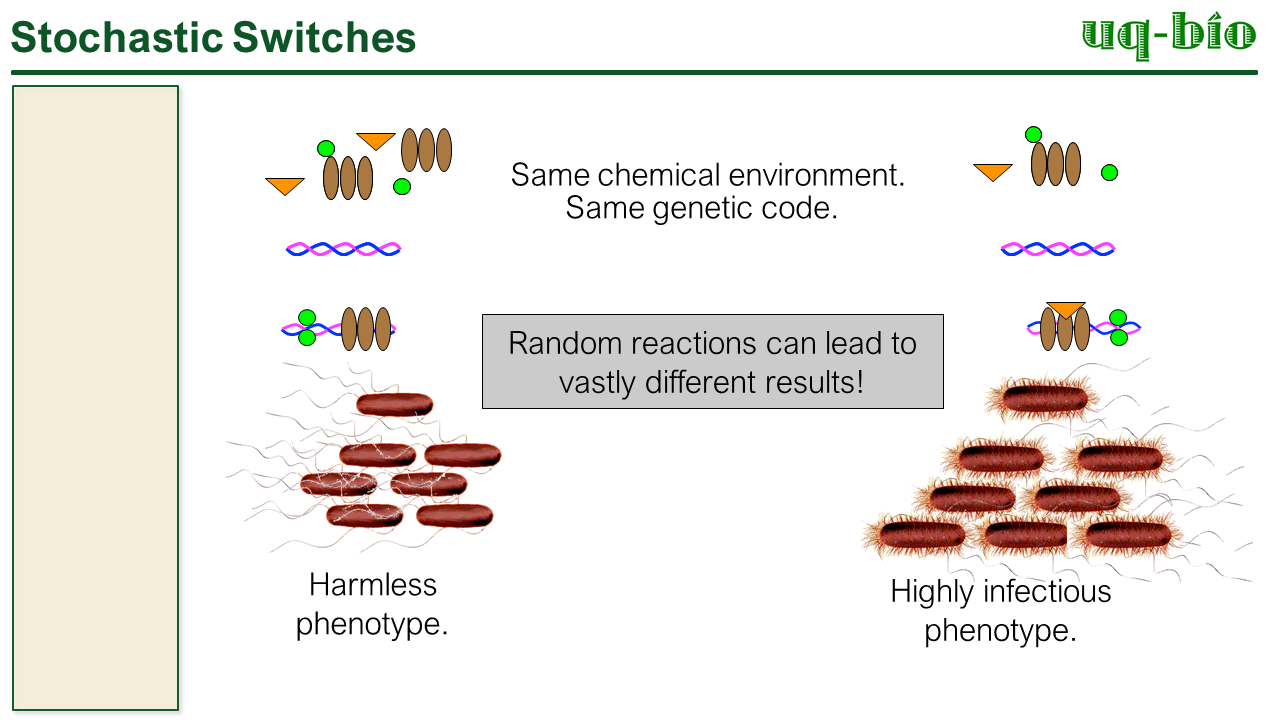

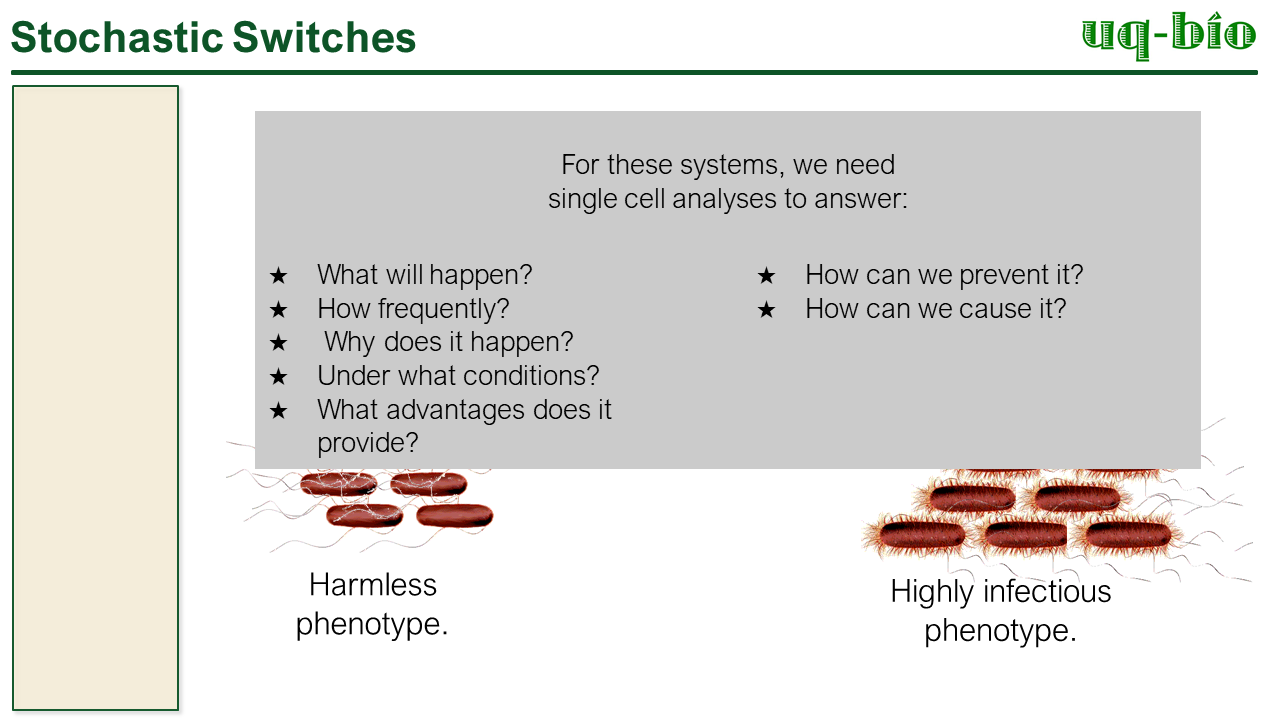

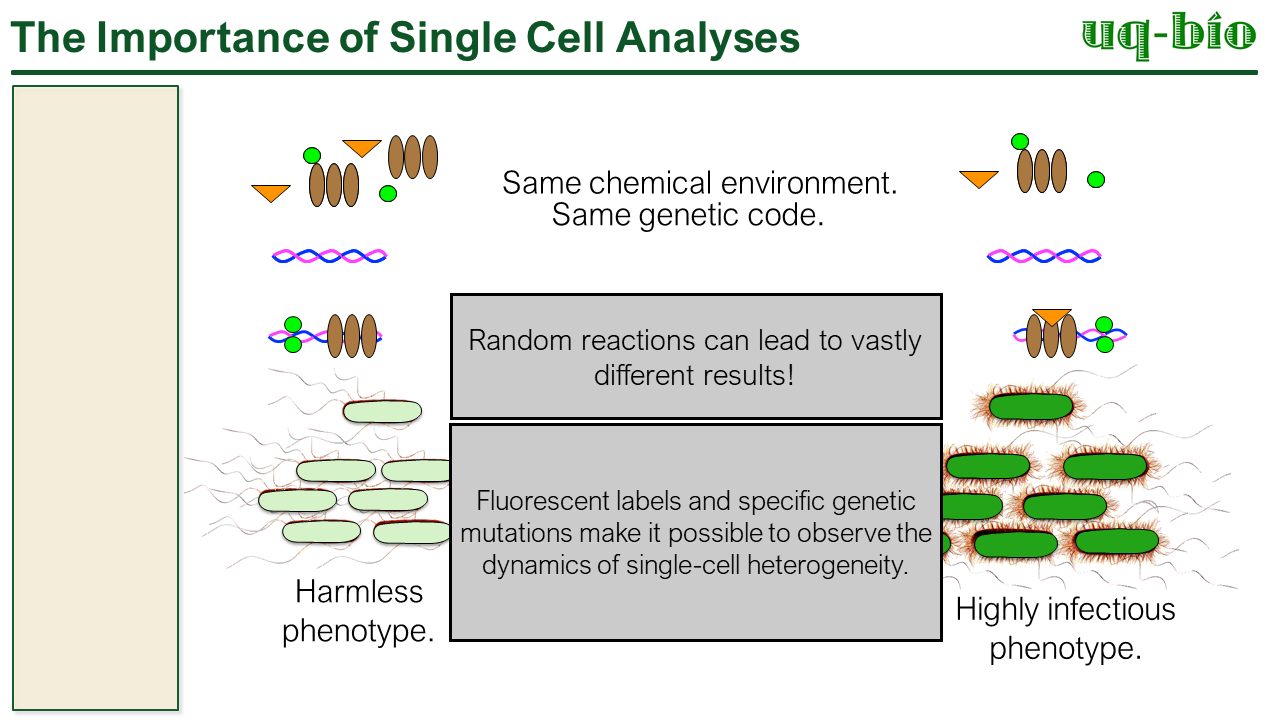

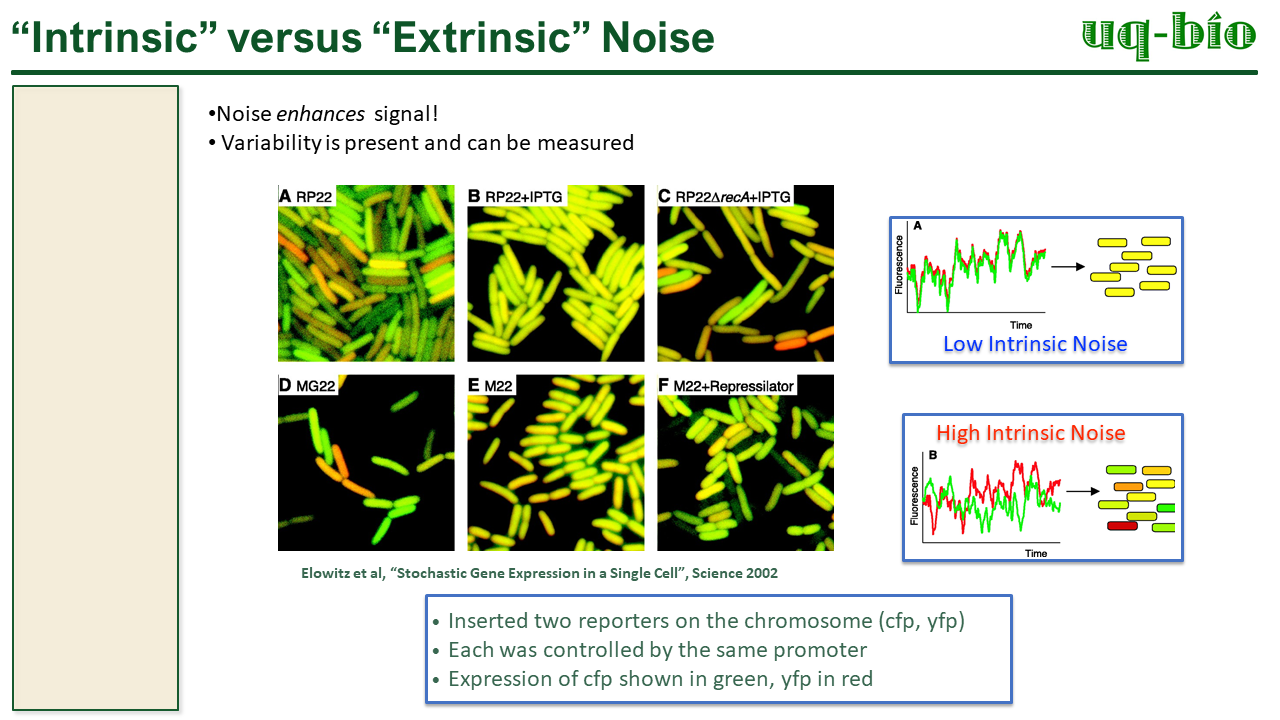

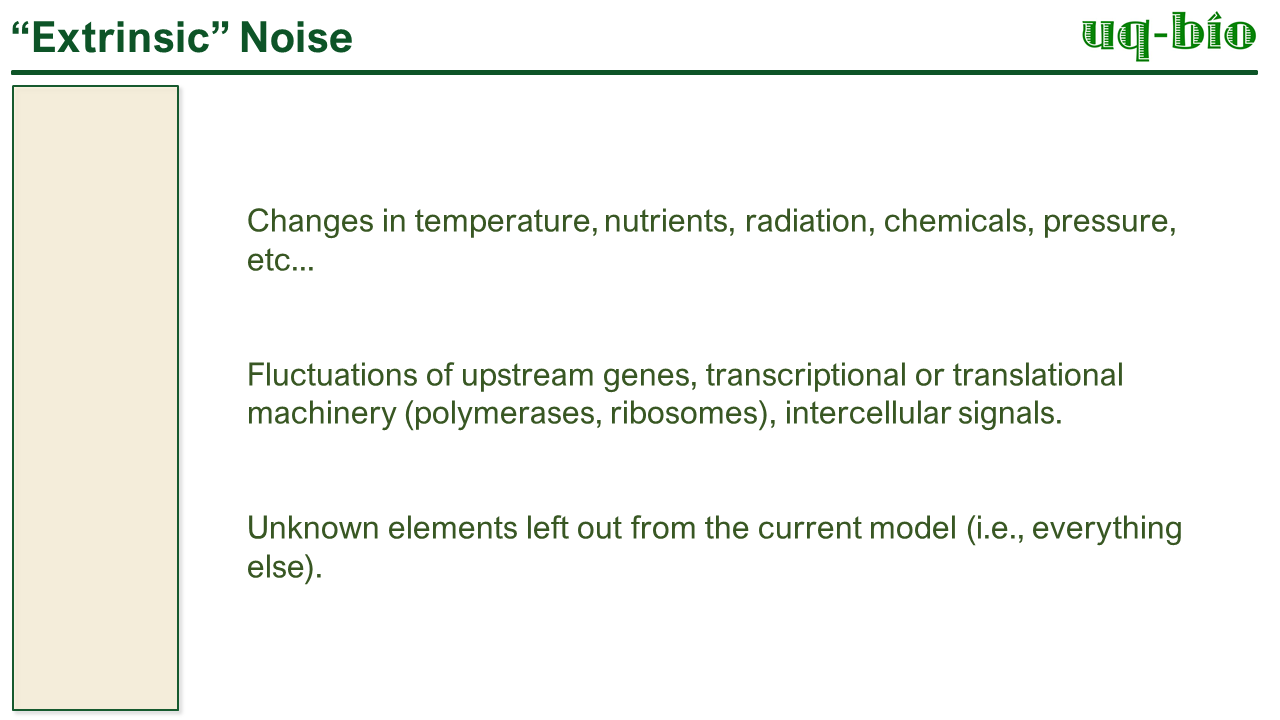

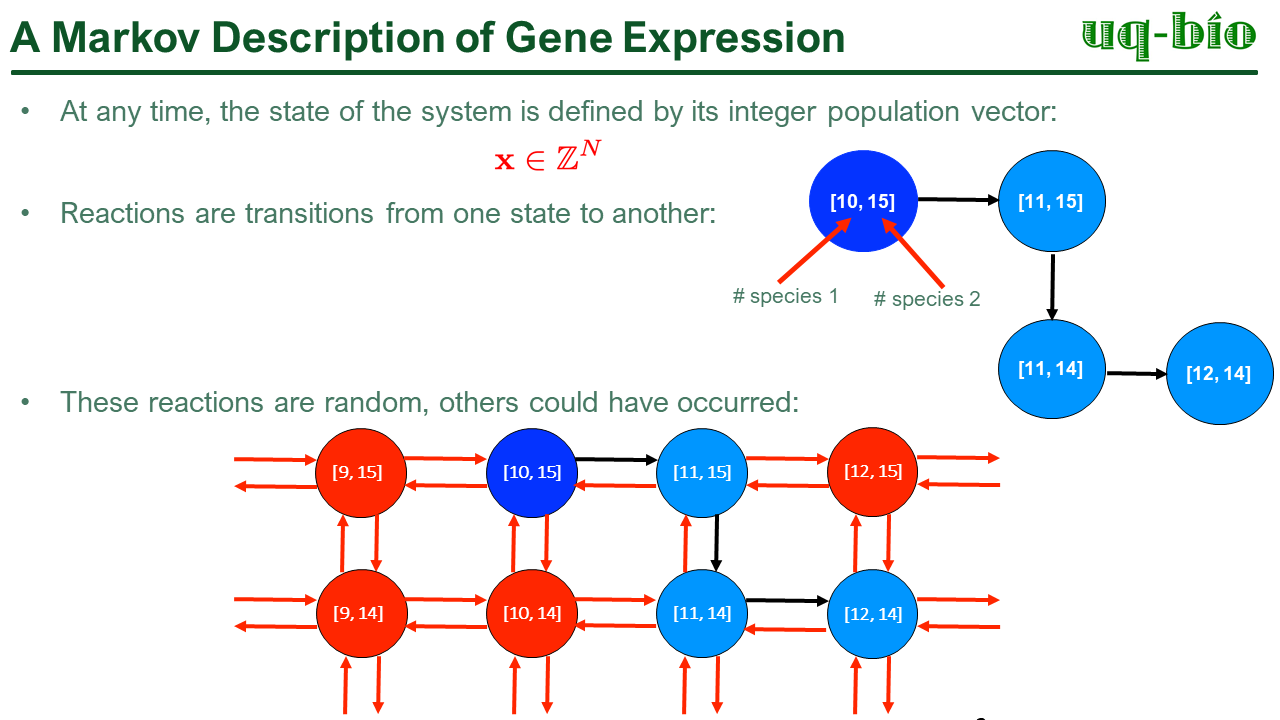

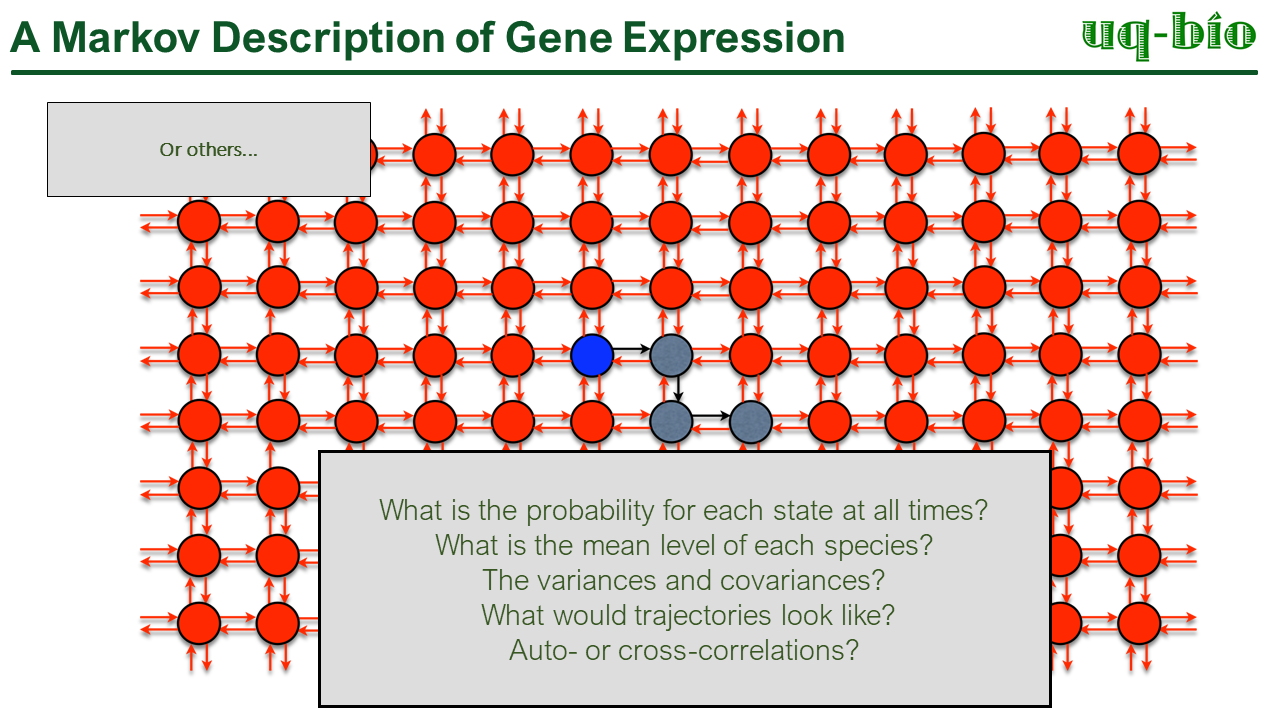

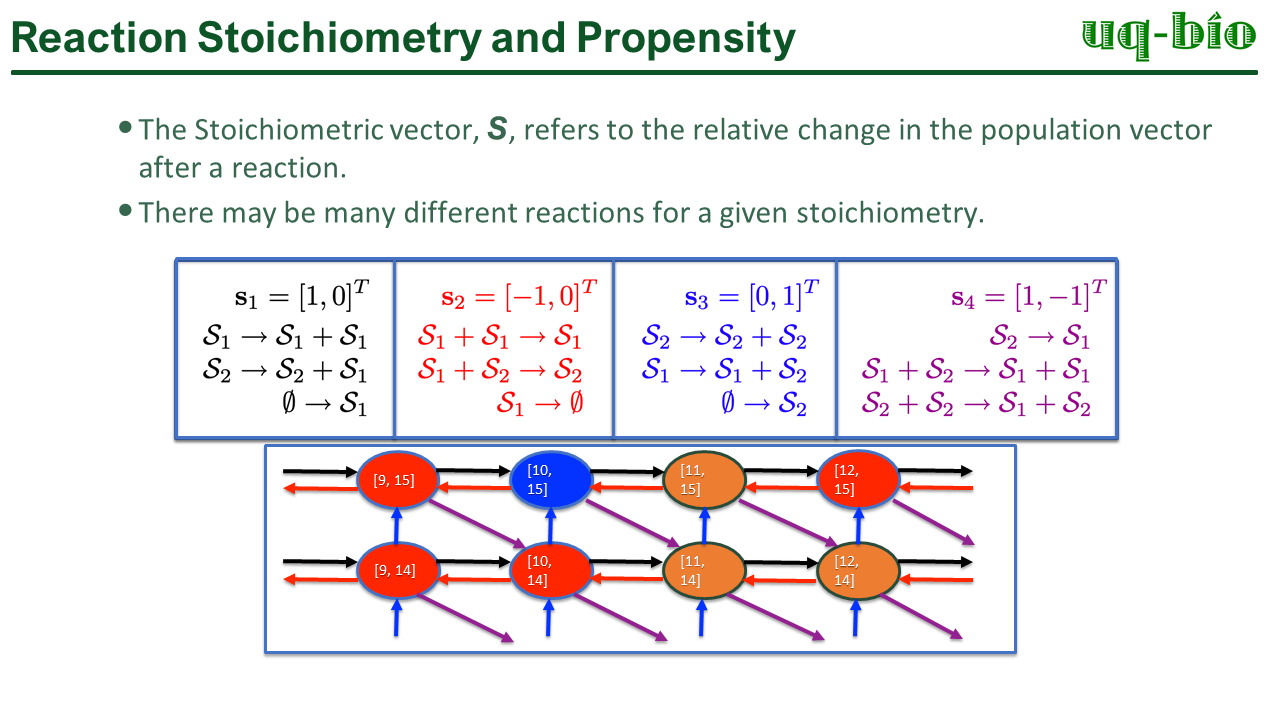

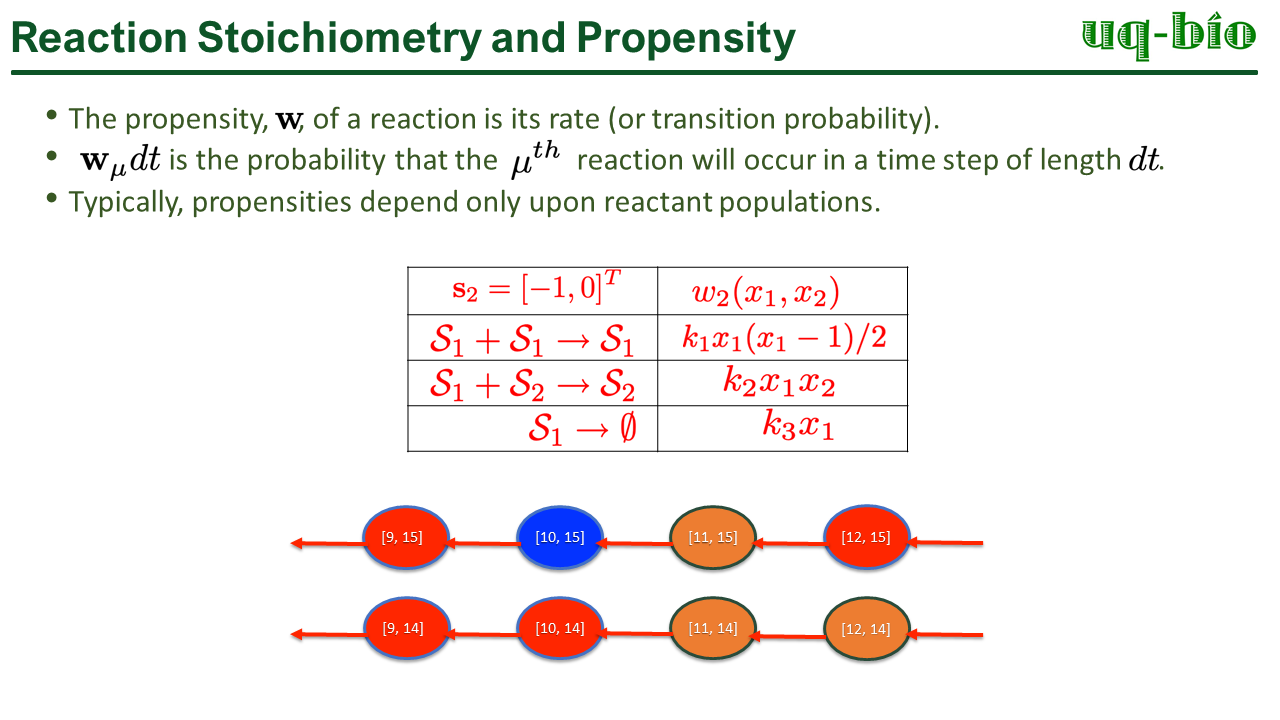

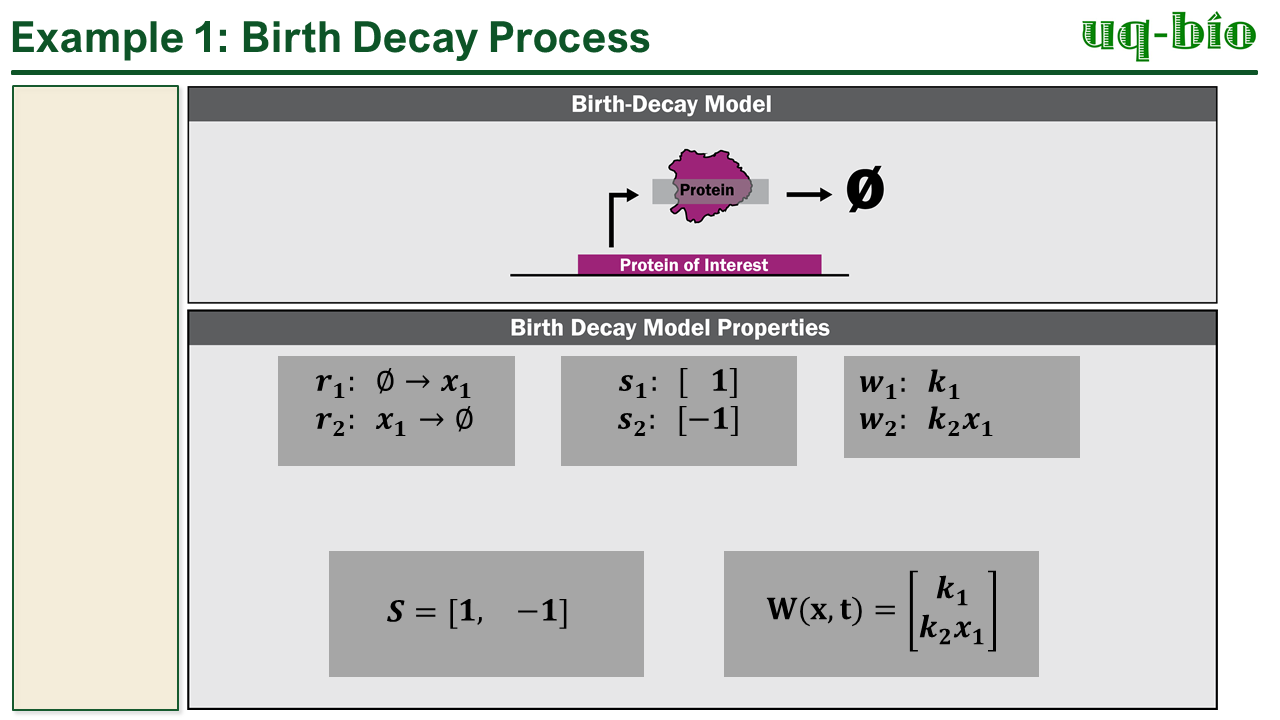

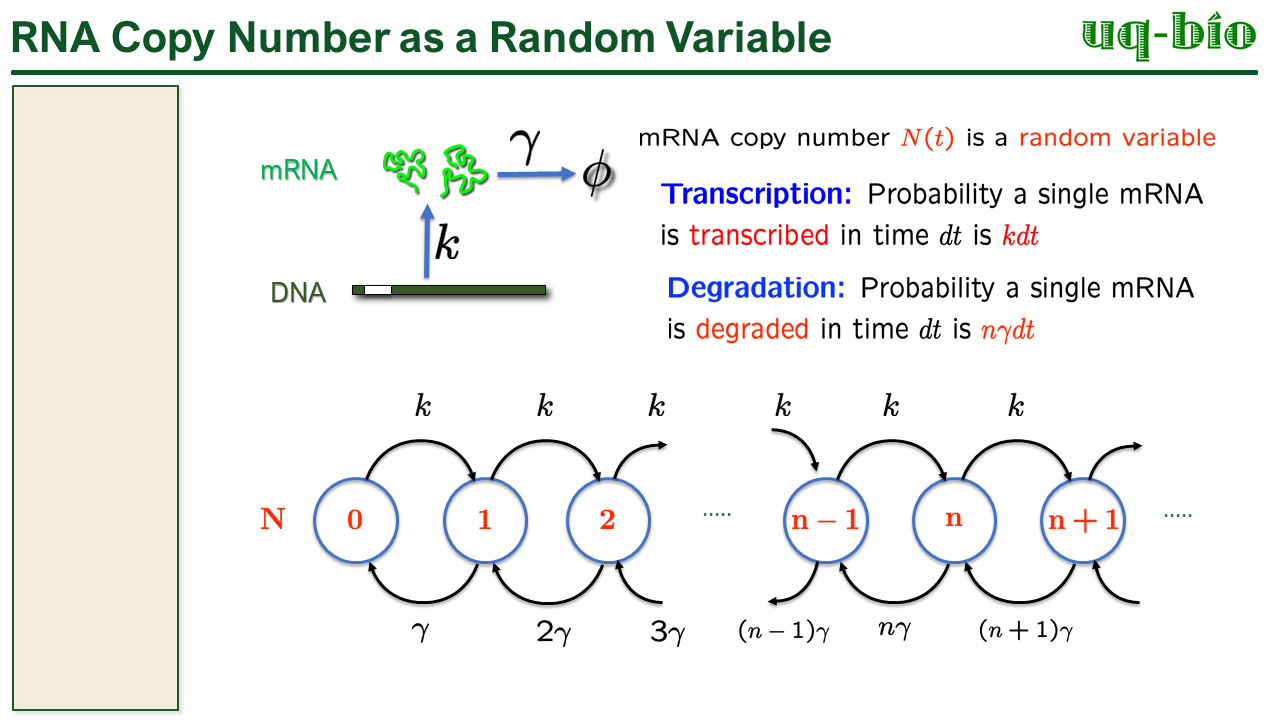

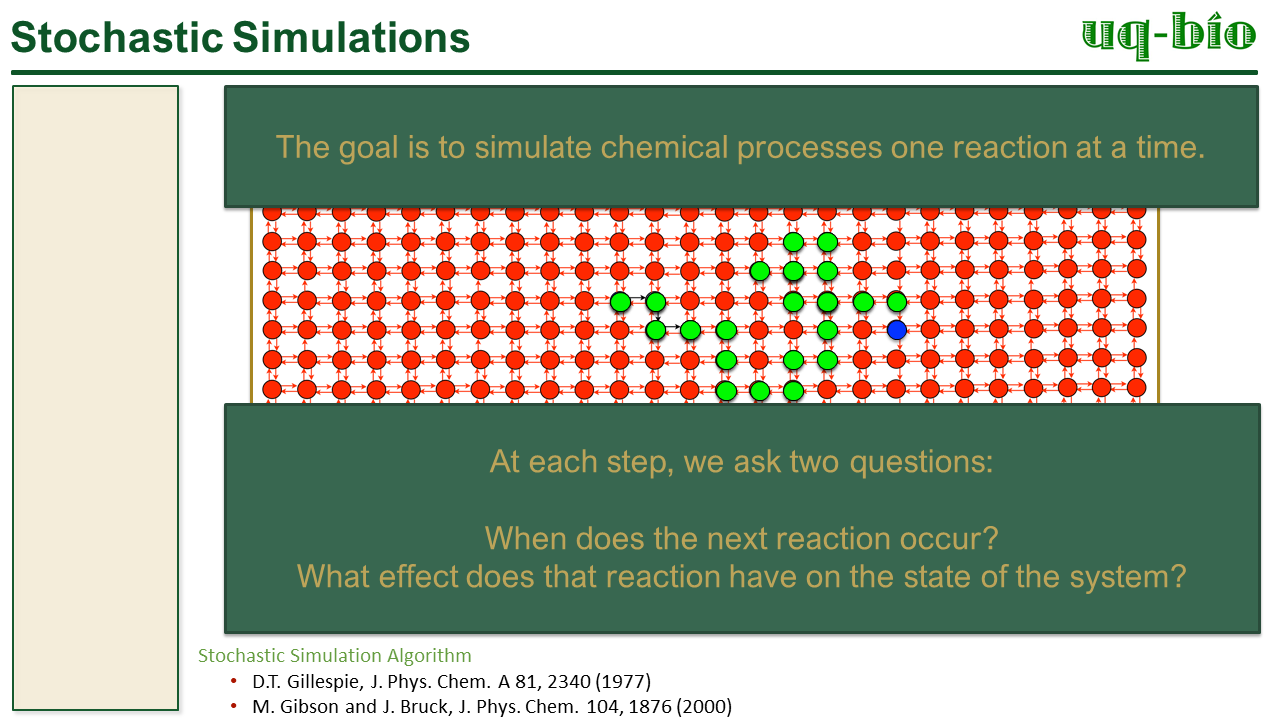

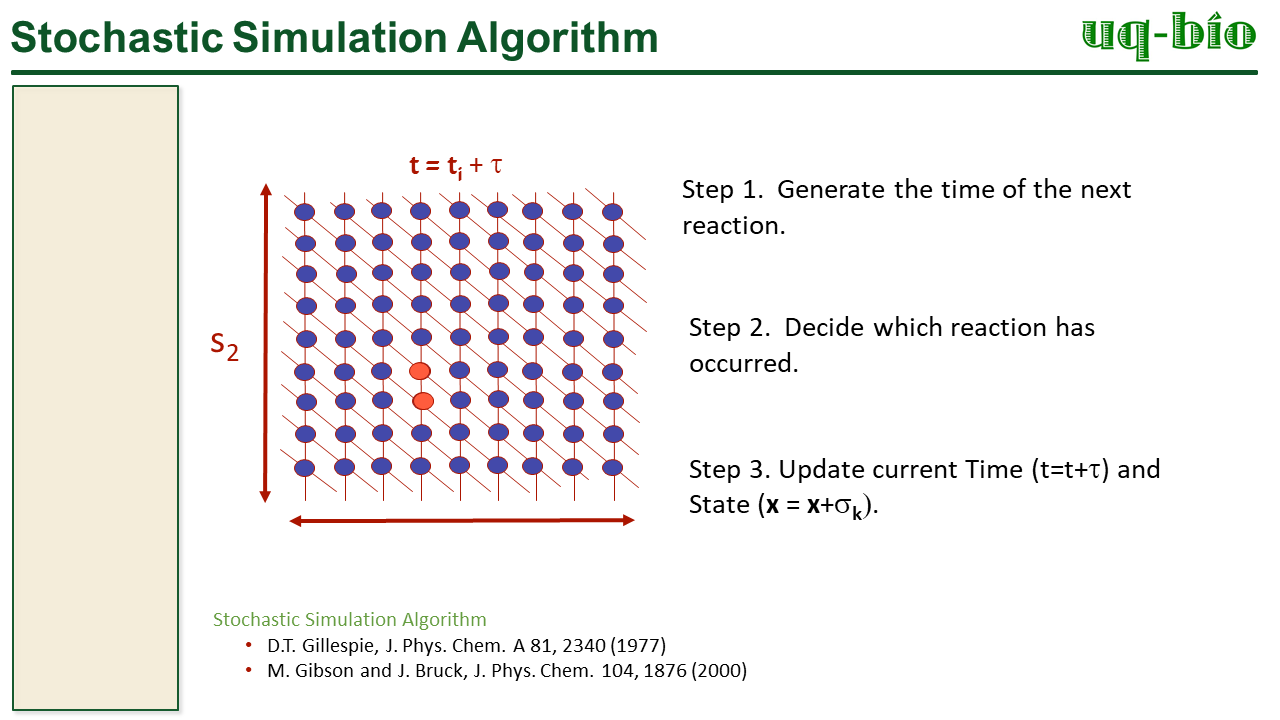

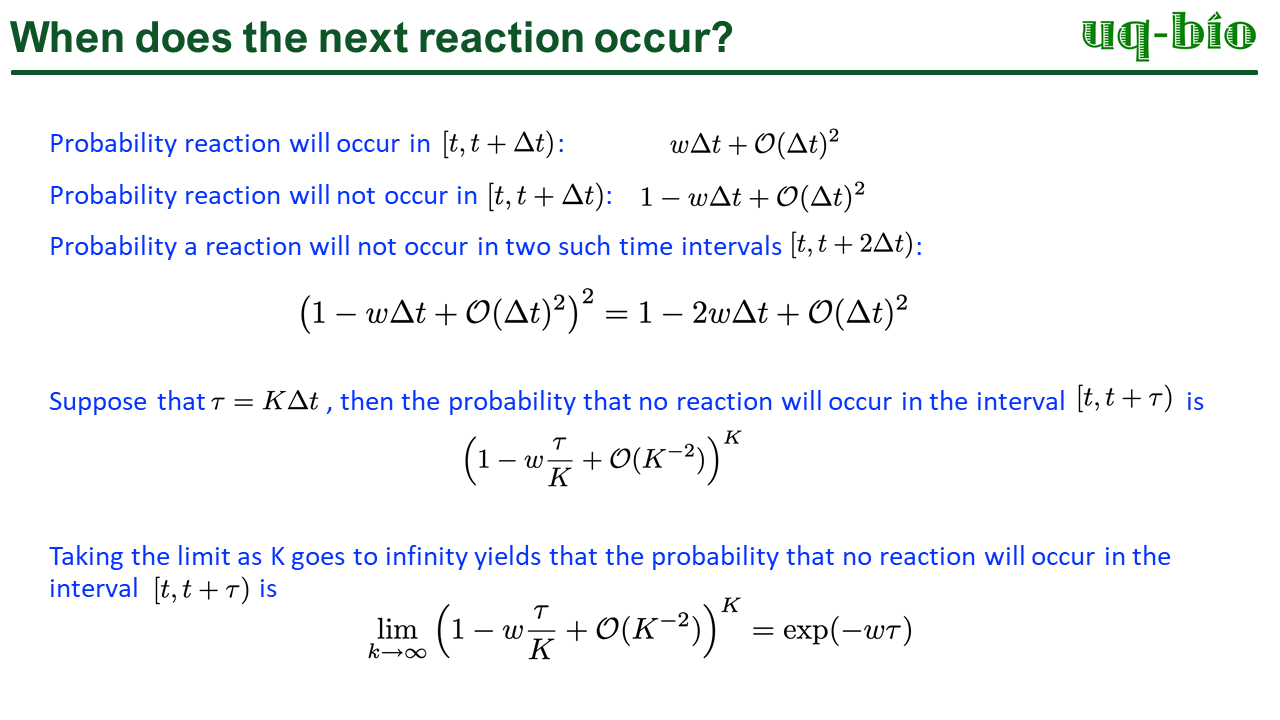

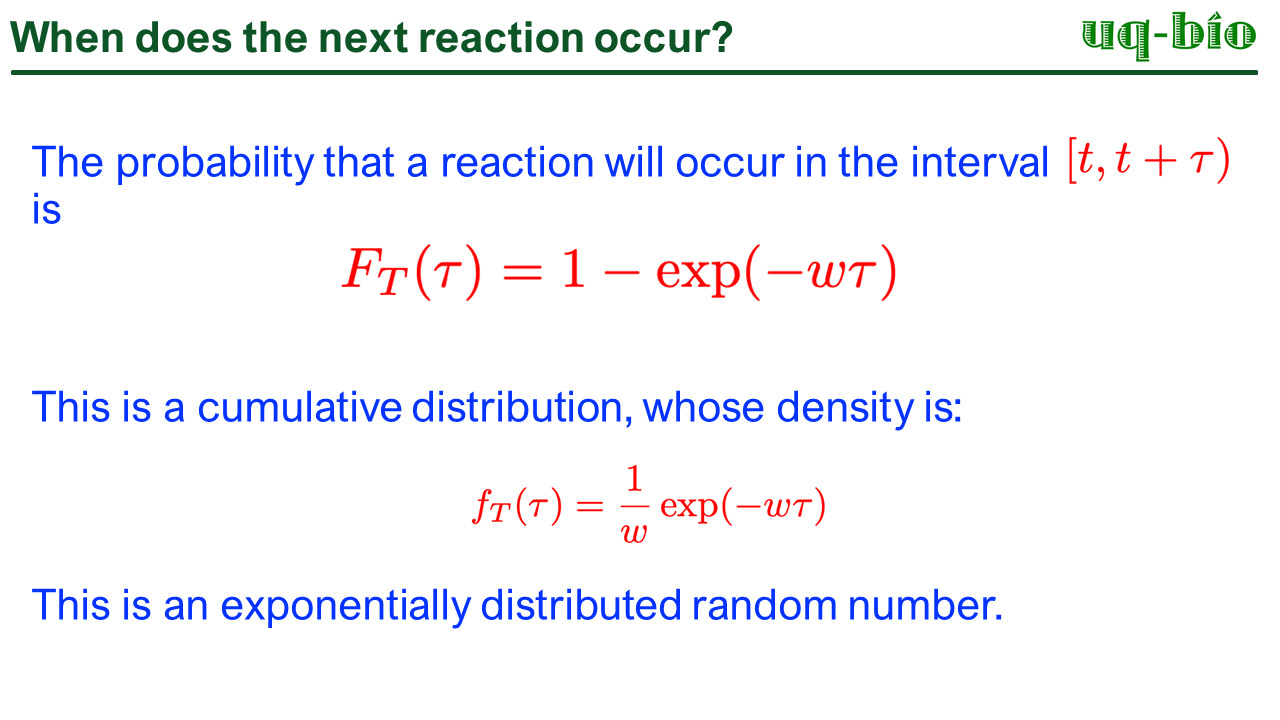

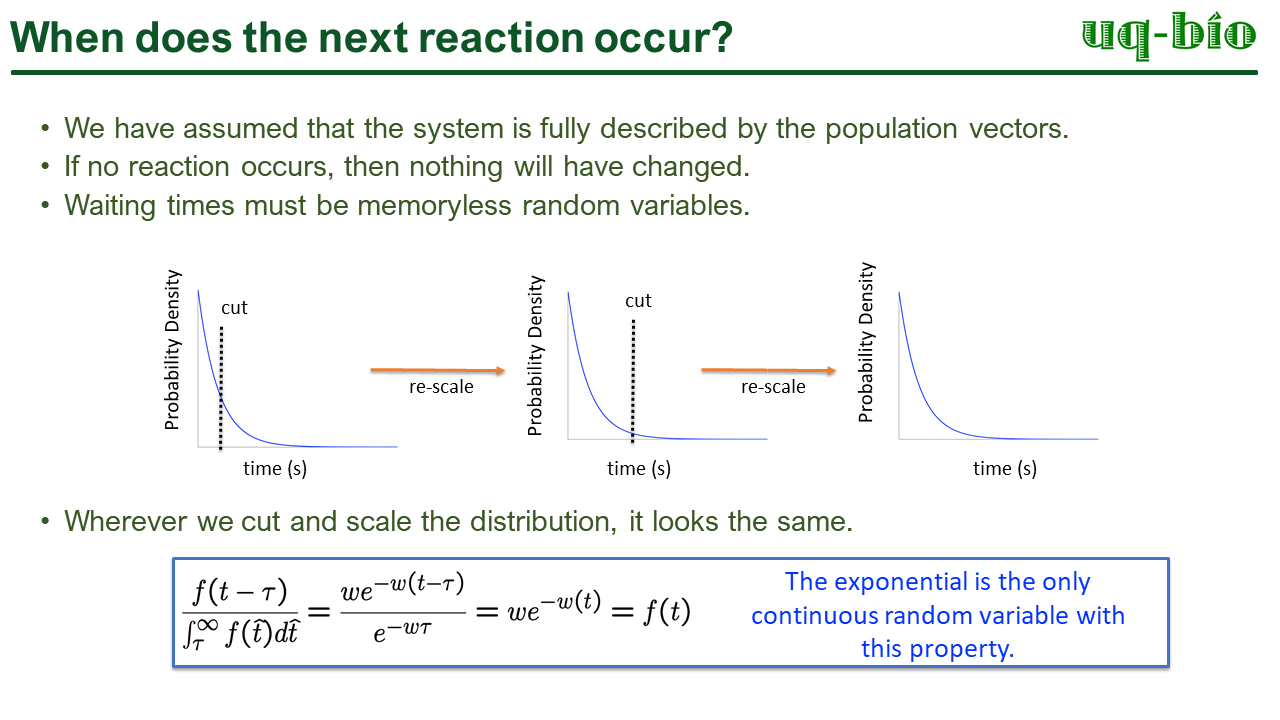

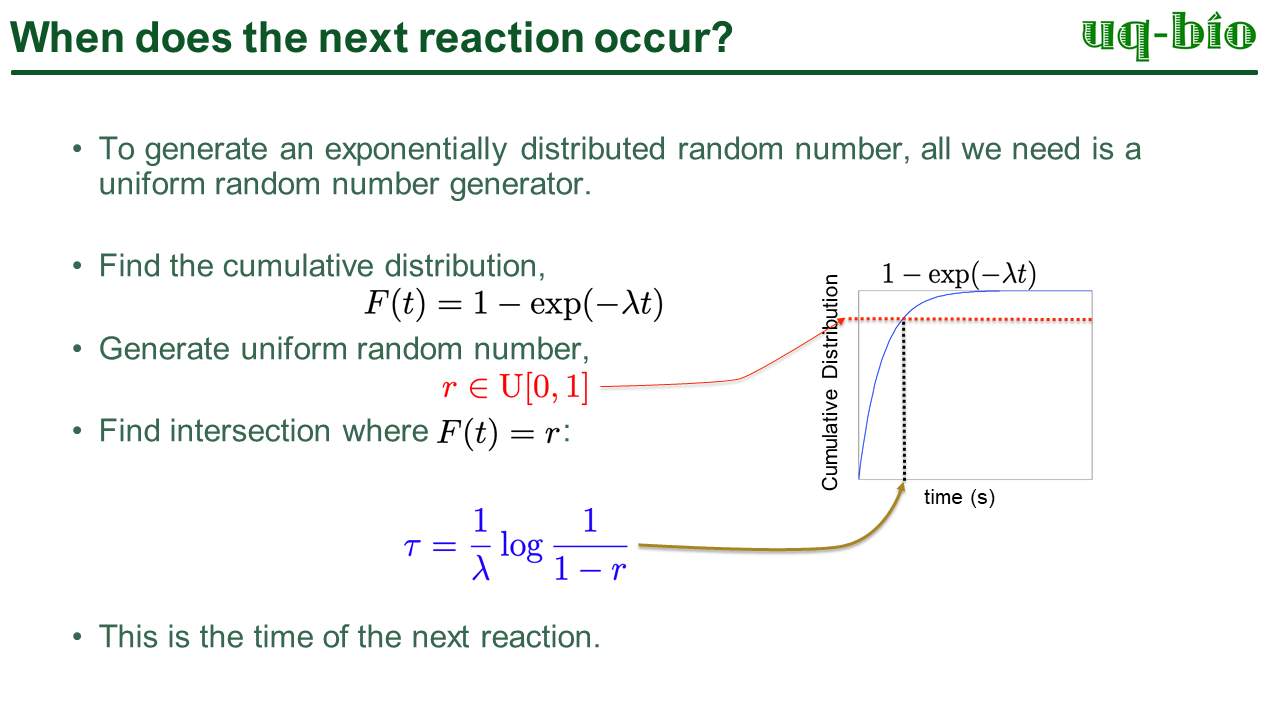

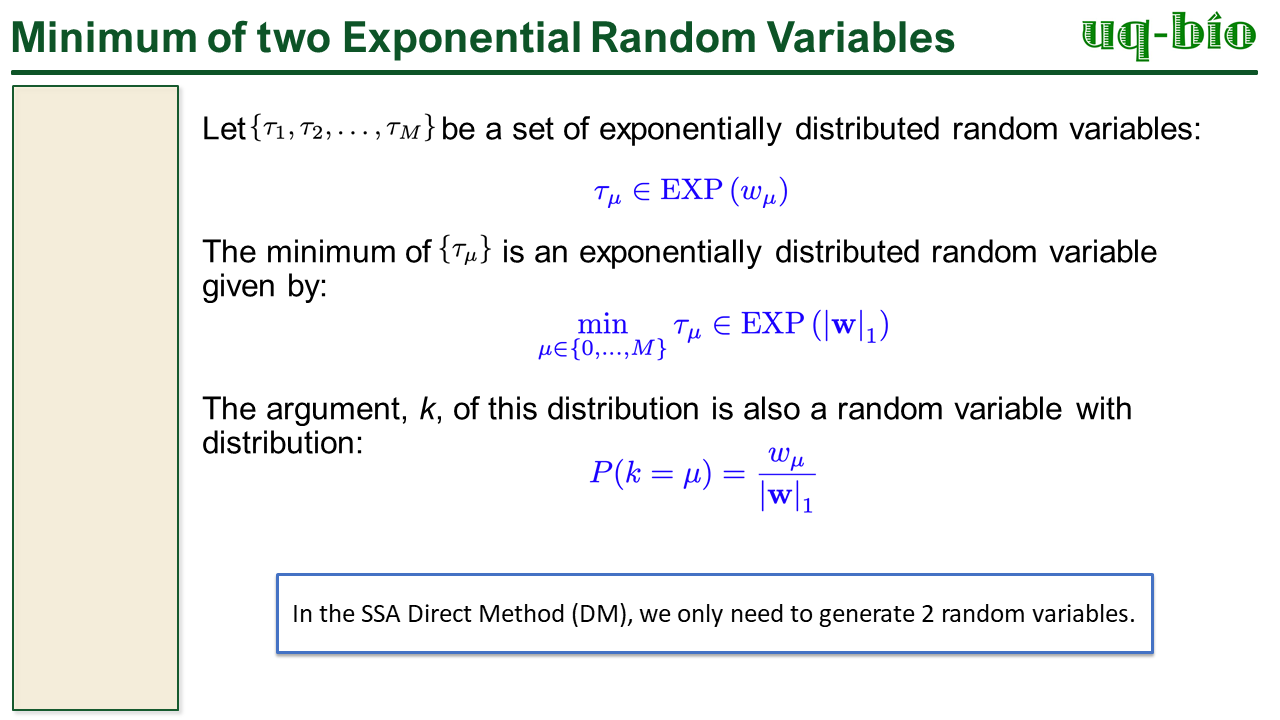

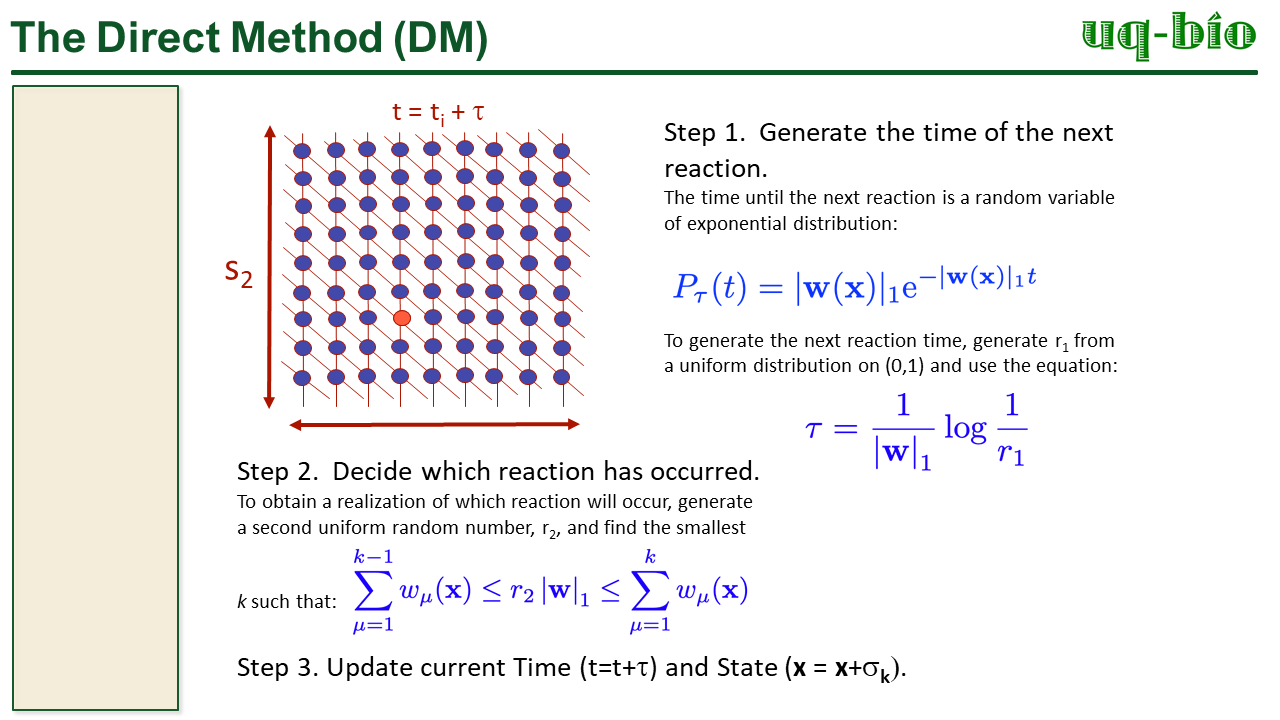

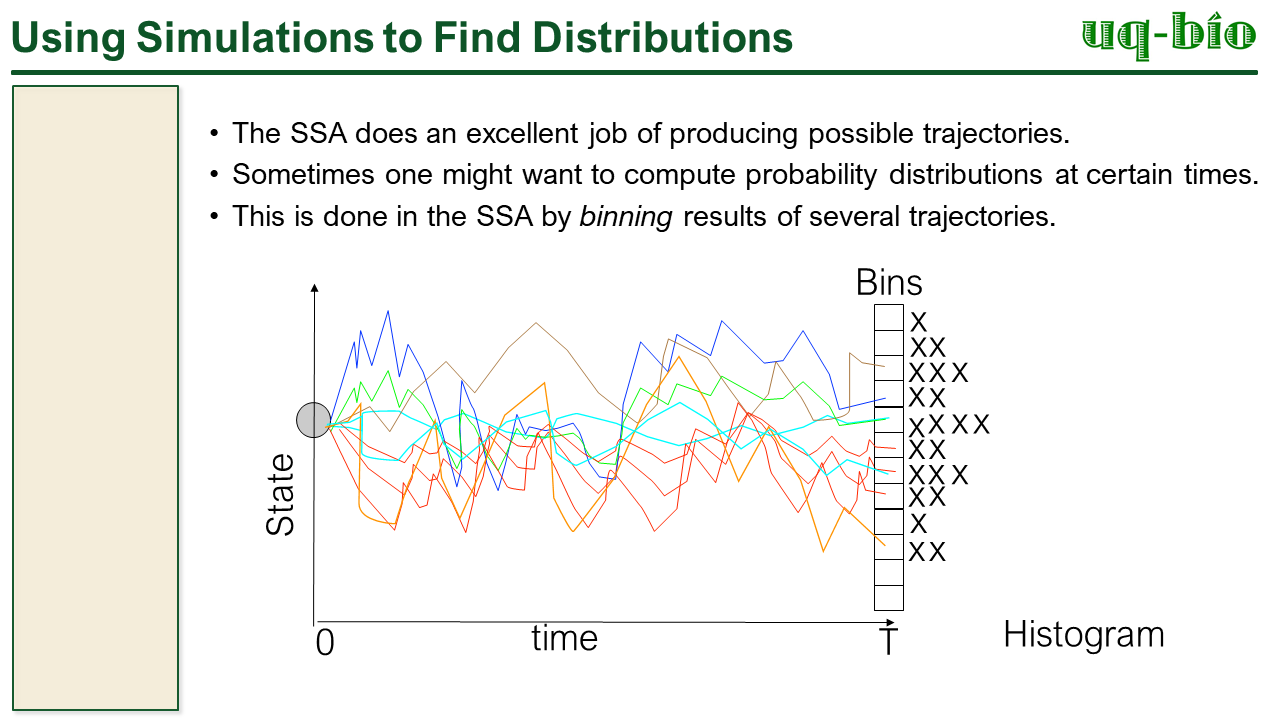

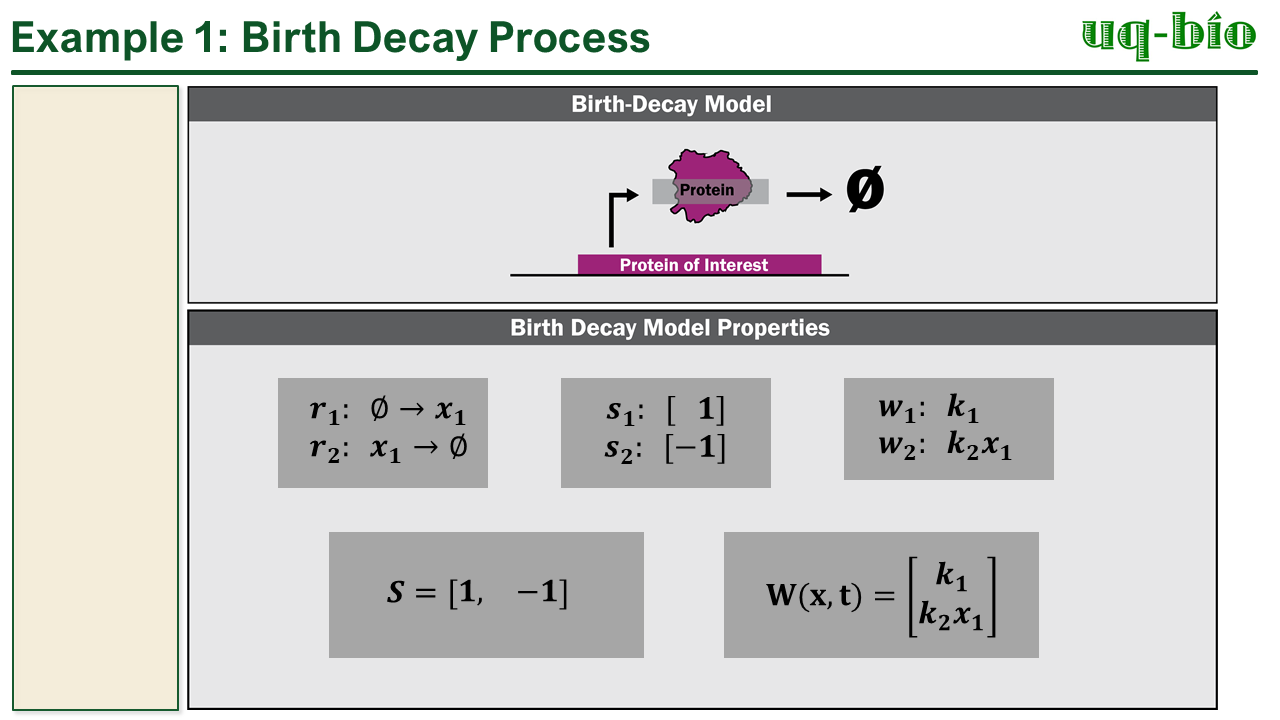

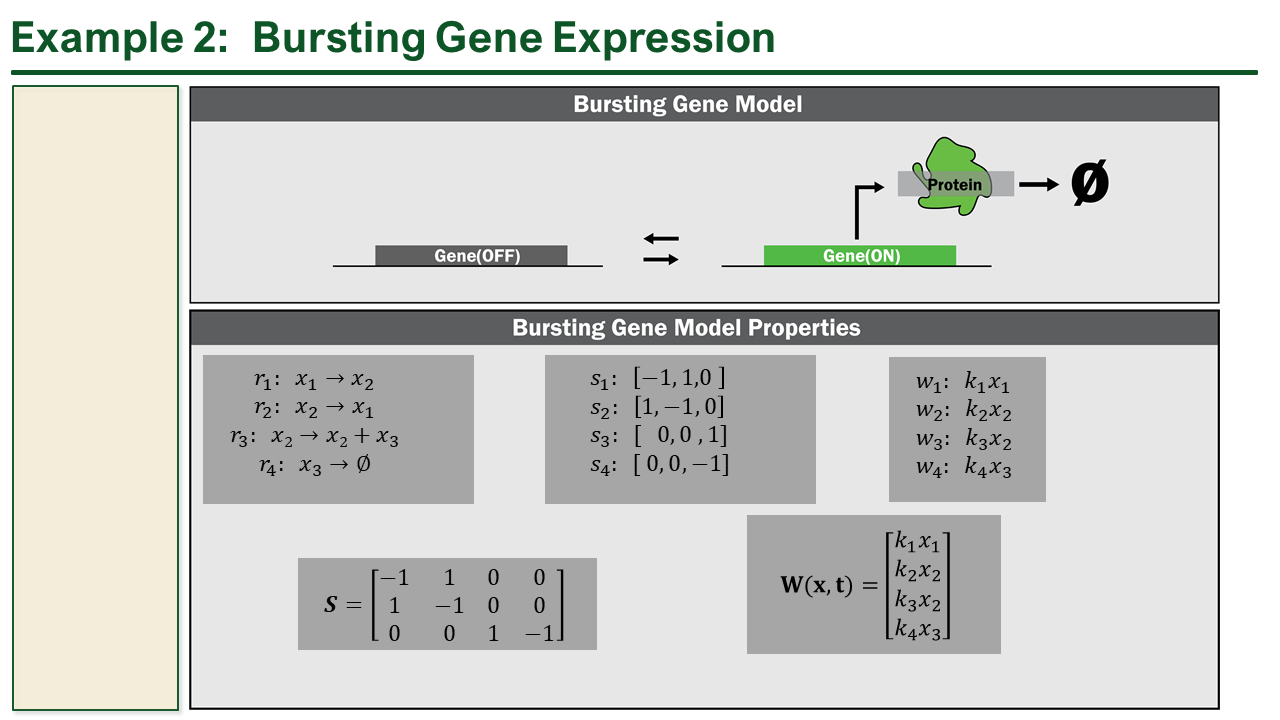

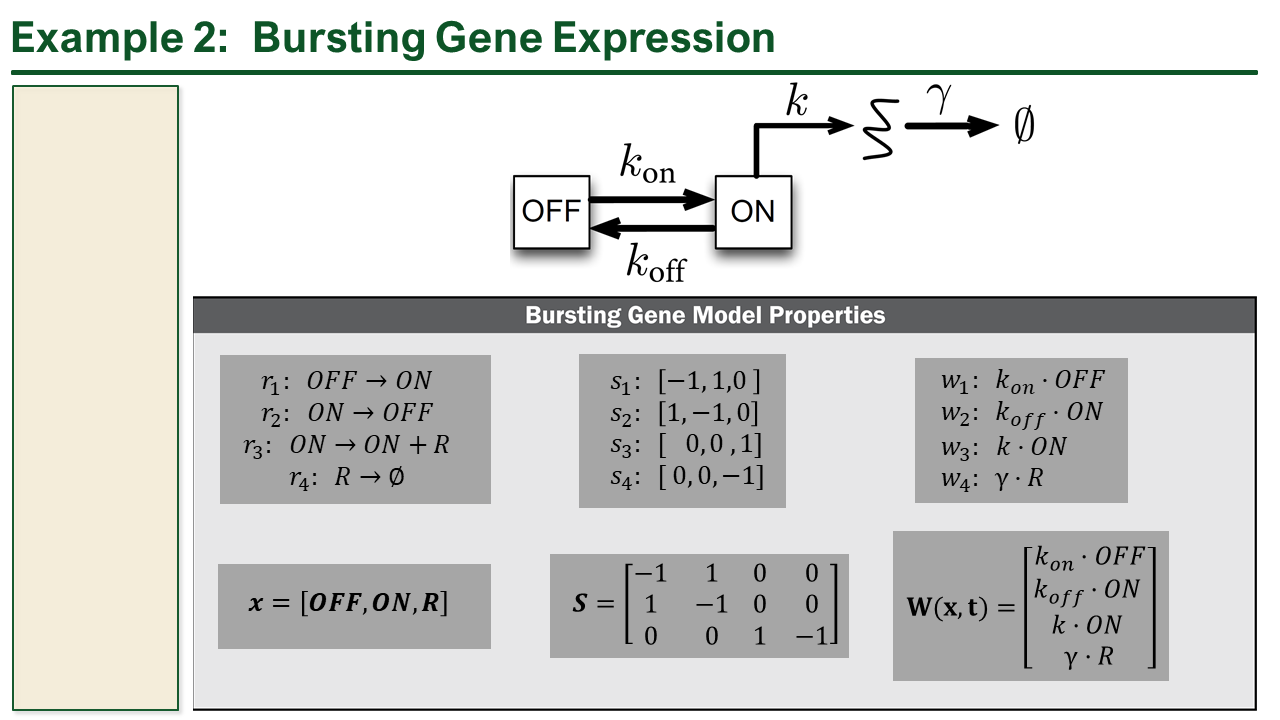

In [1]:
# Import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp 
from scipy.integrate import odeint

Define the parameters, stoichiometry matrix, and propensity functions for the model:

In [2]:
# Vector of Times
t = np.linspace(0, 100, 101) 

# Model Parameters (k_on, k_off, k_mrna, k_mrna_decay)
Pars = np.array([0.2,0.5,10,0.1])
k_on,k_off,k_R,gamma = Pars

# Vector of Initial Conditions (OFF,ON,R)
X = np.array([1,0,0], dtype=int)   # OFF = X[0], ON = X[1], R = X[2]  

# Stoichiometry Matrix -- must be transposed (flipped) 
# Species:    OFF,ON,mRNA
S = np.array([[-1, 1, 0],     # Rxn 1: OFF --> ON  
              [1, -1, 0],     # Rxn 2: ON --> OFF
              [0, 0, 1],      # Rxn 3: ON --> ON + mRNA  (mRNA synthesis)
              [0, 0, -1]]).T  # Rxn 4: mRNA --> phi  (mRNA decay)

# Propensity Functions (anonymous function)
W = lambda X: np.array([[k_on*X[0]],  # Pars[0]*X[0]
              [k_off*X[1]],           # Pars[1]*X[1]
              [k_R*X[1]],             # Pars[2]*X[1]
              [gamma*X[2]]]).T        # Pars[3]*X[2]




**Questions:**

*   Change the code given below **Q2** at the end of the notebook to solve the simpler 1-species pure birth/decay model (i.e., the Poisson Process). Add a plot of the mRNA trajectory over time.  Can you calculate an analytical expression for the steady state mean over time? Add a line for that ODE approximation. 
*   Change the code at the end of the notebook, (**Q3**), to add protein production and degradation to this model. Update the codes and make a plot of the trajectories for the number of active genes, the number of mRNA, and the number of protein.
*  Make another figure that shows the relative fluctuations (e.g., x(t)/mean(x)) for each of the number of active genes, the number of mRNA, and the number of protein.  Comment on how well this matches your what you expectated in the first question (**Q1** at the end of the notebook).  See if you can change the parameters so that the relative variation is about the same for all species.
  * (Space to answer all questions are given at the end of the notebook)



In [3]:
# Function to randomly determine next time and next state using random number generation
# based on the current propensities (exponential waiting time)
def next_jump(W,X):
  current_propensities = W(X)
  total_reactions =current_propensities.shape[1]  # Get total number of reactions
  
  # Update time of next reaction (where tau = 1/w0*log(1/rand)
  time_next_rxn = -np.log(np.random.rand()) / np.sum(current_propensities)

  # Generate random number to select the new reaction to happen based on current state
  random_rate = np.random.rand() * np.sum(current_propensities)

  # Select the new reaction to happen based on current state
  cumulative_prop = np.cumsum(current_propensities)
  for i in range(total_reactions):
    if cumulative_prop[i] >= random_rate:
      rxn_id = i
      break
  return time_next_rxn,rxn_id  ##Return these back out


How does the time until the next reaction and the value to determine the next reaction vary over multiple runs?

* Given the state ($\mathbf{x}$) and a set of propensity functions $\mathbf{w}(\mathbf{x}$): 
 * What is the probability mass function for the reaction numer of the next event?
 *  What is the probability density function for when the next reaction will occur?
 *  What is the probability that no reaction will occur before time $t$?  
 *  Adjust the code to calculate these answers. (Code given in **Q5** at the end of the notebook)

(3,)


Text(0, 0.5, 'Probability')

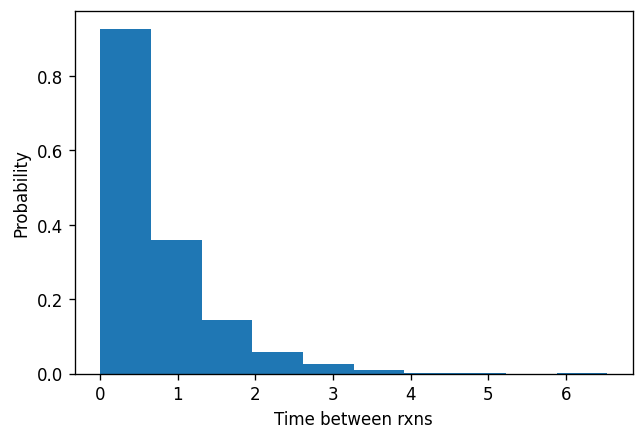

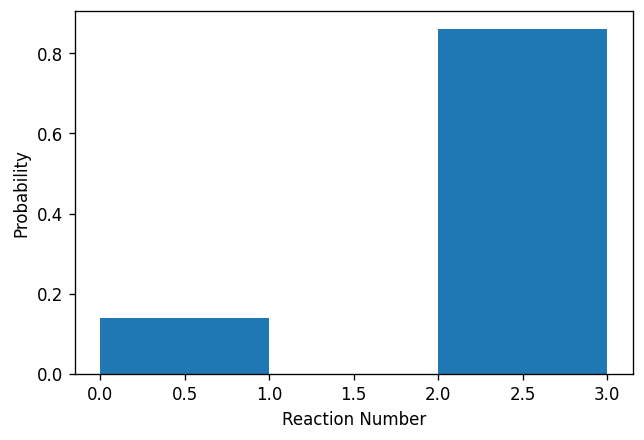

In [4]:
# total number of runs
N = 4257  #@param {type:"slider", min:50, max:10000, step:1}

# Initialize output arrays for next time and next reaction
t_next_rxn = np.zeros(N,dtype=float);
next_rate = np.zeros(N,dtype=int);
X = np.array([1,0,12])   # OFF = X[0], ON = X[1], R = X[2]  

for i in range(0,N): 
  t_next_rxn[i],next_rate[i] = next_jump(W,X);  # Run function to get next time and next reaction  
  
plt.figure(dpi=120)
print(X.shape)
plt.hist(t_next_rxn, density=True)
plt.xlabel('Time between rxns')
plt.ylabel('Probability')
plt.figure(dpi=120)
plt.hist(next_rate,range(0,X.shape[0]+1,1),density=True)
plt.xlabel('Reaction Number')
plt.ylabel('Probability')


The Stochastic Simulation Algorithm:

In [5]:
def SSA_traj(S, W, x0, time_vector):
    total_states = S.shape[0]     # Get total states (number of species)
    x = x0  # Set the state to initial state
    t = time_vector[0]  # Initial time - 1st time in time_vector
    tstop = time_vector[-1]  # Stop time - Last time in time_vector
    record_index = 0  # Initialize counter
    Nt = len(time_vector)  # Total number of time points
    traj_data = np.zeros((total_states, Nt)) # Preallocate for efficiency

    while t < tstop:  # While time is less than last time point
  
        time_next_rxn,rxn_id = next_jump(W,x)  # Run function to get next time and next reaction
        t += time_next_rxn

        while t >= time_vector[record_index]:  # If time passed the record vector, record the state
            traj_data[:, record_index] = x
            record_index += 1   # Update the counter
            if time_vector[record_index] == tstop:  # If counter has moved past the final time point, end and return the data
                traj_data[:, record_index] = x
                return traj_data

        x = x + S[:, rxn_id]  # Update the state based on last reaction




Run the SSA for one trajectory and plot the results:



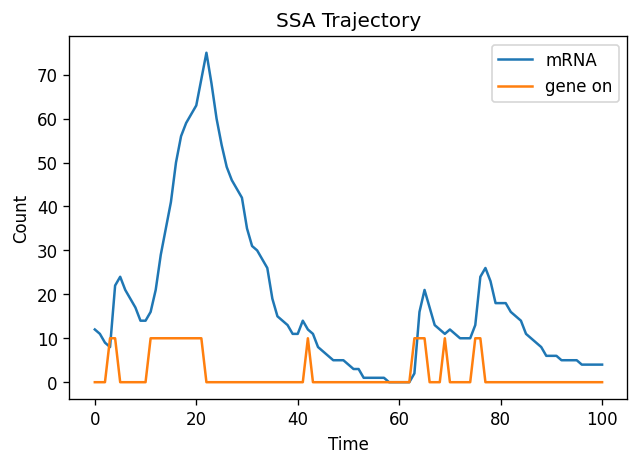

In [14]:
# Run the SSA for a single trajectory
off, on, mRNA = SSA_traj(S, W, X, t)

# Plot the counts from the SSA
plt.figure(dpi=120)
plt.plot(mRNA);
plt.plot(on*10); 
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('SSA Trajectory')
plt.legend(['mRNA', 'gene on'])

**Question:**

*   How could the reaction contstants k_on, k_off, k, and gamma be found from the SSA trajectories?
* Consider the bursting gene model from above. How could you adjust the parameters {k_on, k_off, k, and gamma} so that the average time between bursts is 2 minutes, the average burst lasts for 0.5 minutes, the average mRNA count during a burst is 20, and bursts decay with a half life of 0.25 minutes after turning off?
  * (Space to answer all questions are given at the end of the notebook, **Q6**)

Interactive parameter trajectory and plot:

Text(0, 0.5, 'Count')

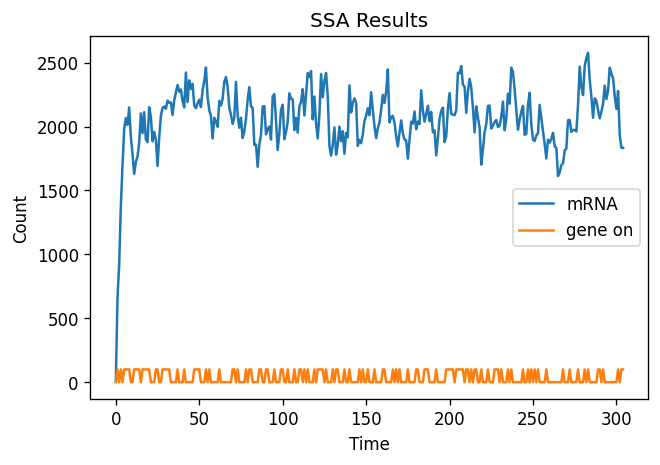

In [7]:
# Parameters 
tf =  9805 #@param {type:"slider", min:100, max:10000, step:1}
tstep = 305 #@param {type:"slider", min:100, max:10000, step:1}
k_on_2 = 0.71 #@param {type:"slider", min:0.01, max:100, step:0.1}
k_off_2 = 0.91 #@param {type:"slider", min:0.01, max:100, step:0.1}
k_R_2 = 47.81 #@param {type:"slider", min:0.01, max:1000, step:0.1}
gamma_2  = 0.01 #@param {type:"slider", min:0.01, max:1000, step:0.1}


# Propensities (anonymous function)
W_2 = lambda X: np.array([[k_on_2*X[0]],  # Pars[0]*X[0]
              [k_off_2*X[1]],             # Pars[1]*X[1]
              [k_R_2*X[1]],               # Pars[2]*X[1]
              [gamma_2*X[2]]]).T          # Pars[3]*X[2]

# Time vector
t_2 = np.linspace(0,tf,tstep)  

# Run SSA function to solve for population vector, x=[off, on, mRNA]
off, on, mRNA = SSA_traj(S, W_2, X, t_2)

# Plot the SSA results (population counts for ON state and mRNA)
plt.figure(dpi=120)
plt.plot(mRNA);
plt.plot(on * 100);
plt.legend(['mRNA', 'gene on'])
plt.title('SSA Results')
plt.xlabel('Time')
plt.ylabel('Count')




To generate and plot multiple trajectories, use a loop structure:




  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0, 'Probability Estimate')

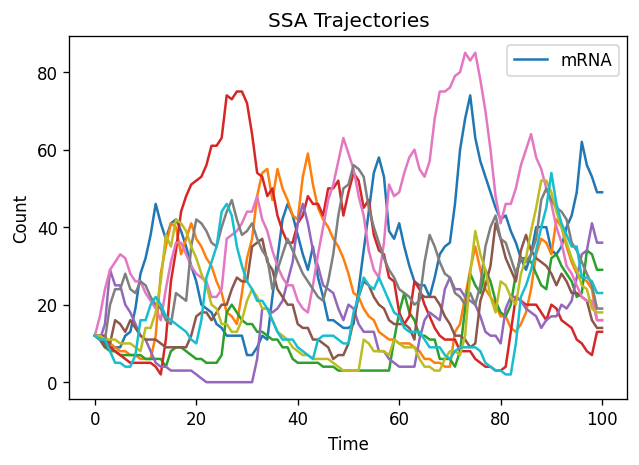

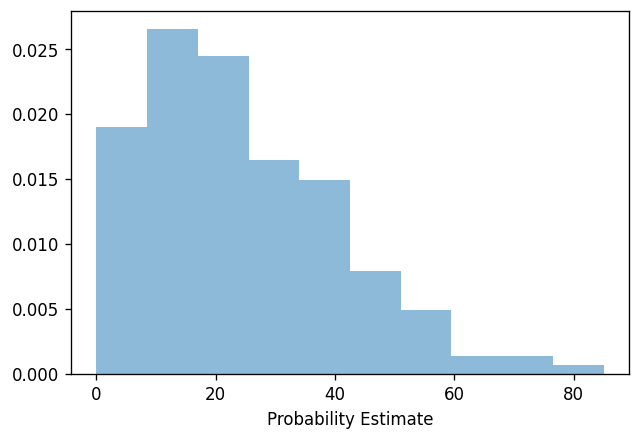

In [8]:
import tqdm.notebook as tq #progress bar 
# Run the SSA for a multiple trajectories
# Total trajectories to run
N_runs = 10   #@param {type:"slider", min:10, max:100, step:1}

# Initialize output array
counts = np.empty((X.shape[0], len(t), N_runs), dtype=int)

for i in tq.tqdm(range(0,N_runs)): # Use the progress bar
  # Run SSA code for N_runs (number of) trajectories
  counts[:,:,i]= SSA_traj(S, W, X, t)

# Specify position of each species in outlet variable, counts
OFF = counts[0,:,:]
ON = counts[1,:,:]
R = counts[2,:,:]

# Plot the mRNA counts from the SSA
plt.figure(dpi=120)
plt.plot(t,R); 
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('SSA Trajectories')
plt.legend(['mRNA'])

# Let's take a look at the mRNA count distributions from all of the SSA runs
plt.figure(dpi=120)
plt.hist(R.flatten(),bins=10,density=True,alpha=.5);
plt.xlabel('mRNA Count')
plt.xlabel('Probability Estimate')

# The above is plotting the historam of results integrated over all times.
# What would you do if you only wanted the distribution at the final time?



Some analysis of the SSA results:

**Tasks:**

*   Calculate the standard deviation and variance in mRNA count from all SSA trajectories.
- Calculate the Fano factor, which is the ratio of the variance and the mean of the mRNA copy number. The Fano factor quantifies the deviation from Poisson statistics.






23.3


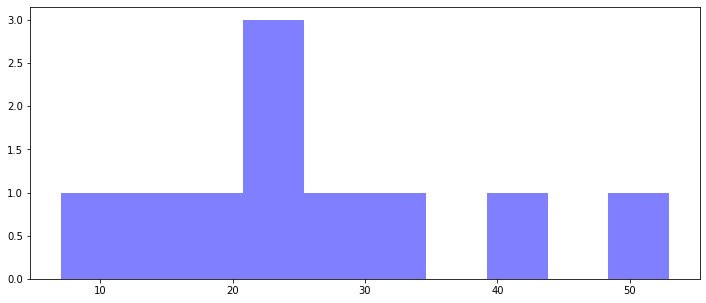

In [17]:
# Determine the mean mRNA from all SSA trajectories:
mean_mrna_ssa = np.mean(R,axis =1)
print(mean_mrna_ssa[-1])

# To look at the mRNA distribution at different times, 
# we can plot a histogram for all SSA trajectories at a given time point.
# For this, we use the function "hist" from matplotlib.
selected_time_point = 98 #@param {type:"slider", min:0, max:100, step:1}
plt.figure(figsize=(12,5))
plt.hist(R[selected_time_point,:], color ='blue',alpha=0.5)
plt.show()

# Determine the mRNA standard deviation and variance:




Compare the SSA results for mRNA Copy Number to the ODE (deterministic) solution:


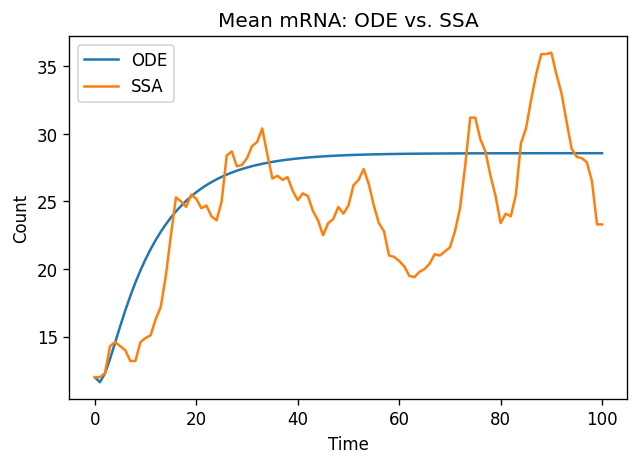

In [16]:
#ODE model of 2 state bursting gene expression
def Gene_Model(X,t,pars = Pars):

    # Model Parameters (k_on, k_off, k_mrna, k_mrna_decay)
    k_on,k_off,k_R,gamma = Pars

#Set of ODEs that describe 2-state bursting gene expression with transcription
    dxdt = [k_off*X[1]-k_on*X[0], # OFF state ODE (State 1)
            k_on*X[0]-k_off*X[1], # ON state ODE (State 2)
            k_R*X[1]-gamma*X[2]] #in out of RNA
    return dxdt

# Solve the ODEs for the system
x0 = np.array([1,0,12])
Pars = [k_on,k_off,k_R,gamma]
ODE_soln = odeint(Gene_Model,x0,t,args=tuple([Pars,]))
mRNA_ode = ODE_soln[:,2]  # Specify the mRNA results from solving the ODE

# Plot the mean mRNA count from the SSAs compared to the ODE solution
plt.figure(dpi=120)
plt.plot(t,mRNA_ode); 
plt.plot(t,mean_mrna_ssa)
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Mean mRNA: ODE vs. SSA')
plt.legend(['ODE','SSA'])

**Question:**
*   How would you show that the stochasticity of the SSA projection is matching the ODE?
*   Create a graph to show this.

  * (Space to answer all questions are given at the end of the notebook, **Q7**)

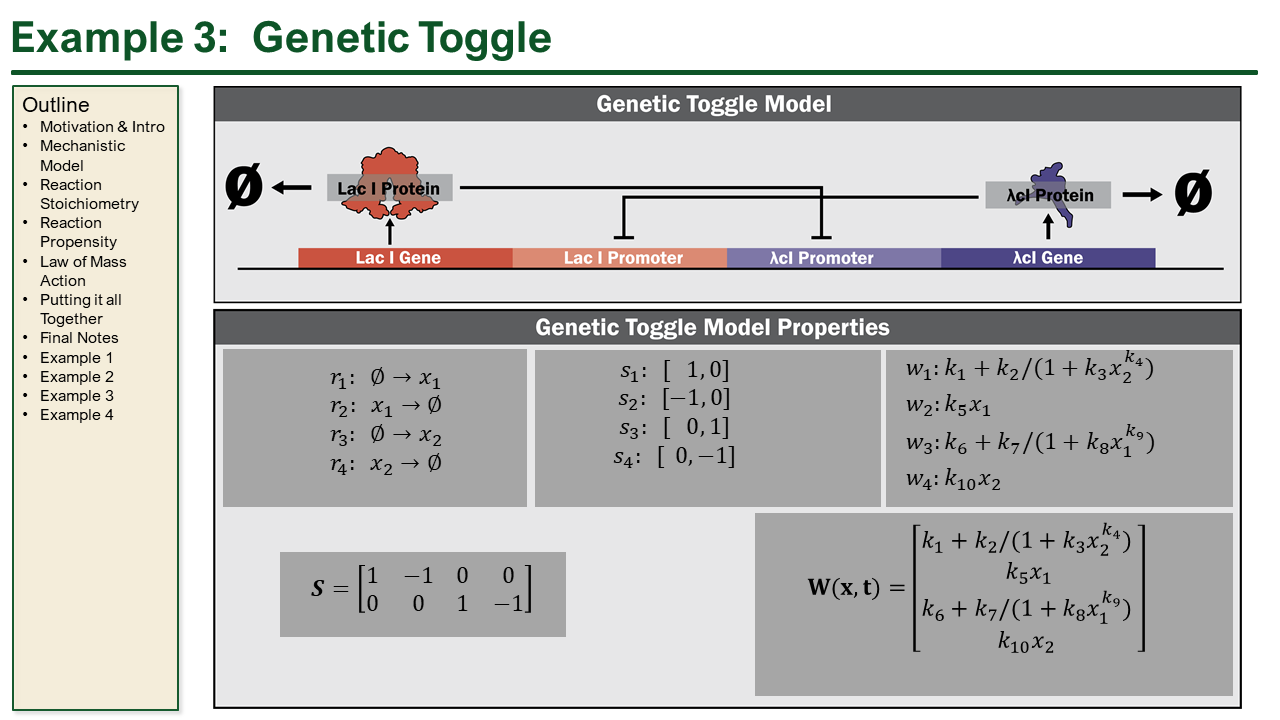

In [27]:
# protien synth/ degrade model:

# Vector of Times
t_p = np.linspace(0, 100, 101)

# model paramters (k_on, k_off, k_mrna, k_mrna_decay)

Pars = np.array([5, 50, 10, 0.1, 1, 5, 50, 1, 1, 1])
k1, k2, k3, k3, k4, k6, k7, k8, k9, k10 = Pars

# Vector of Initial Conditions (OFF, ON, R)
k10

1.0

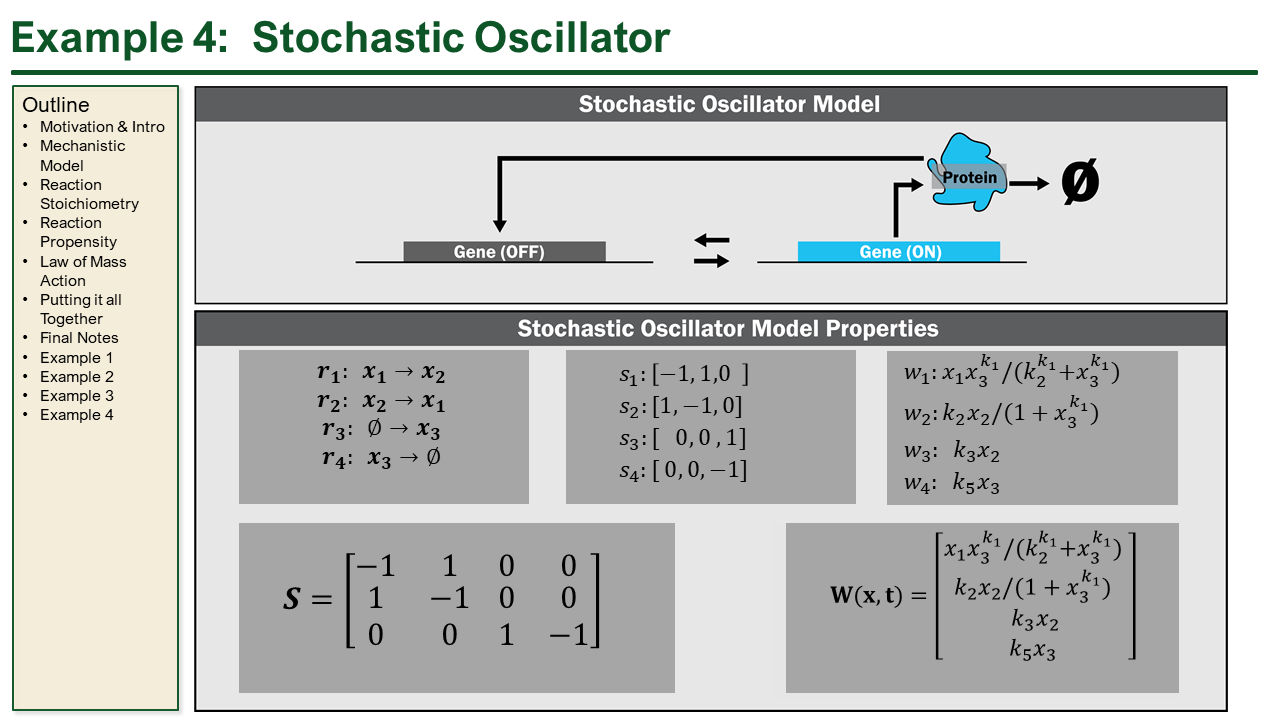


**Additional Exercises:** **Q8**

- Modify the stoichiometry matrix and propensity functions for the other example models provided. 
    - Example 1: Birth/Decay Model
    - Example 3: Genetic Toggle
    - Example 4: Stochastic Oscillator
- Run the SSA for each of these example models. How do the results differ from the 2-state bursting gene model? 
- In linear models, the mean level behavior is the exact same as the deterministic model but this isn't true for non-linear models. What would happen in the cases where the propensity function is concave/convex?

 -   Write a code to formulate and simulate a one species stochastic system with a convex (e.g., $k*x^2/(M+x)$) production rate propensity function and one with a convex propensity function (e.g., $k*\sqrt{x}$) production rate propensity function. Plot the average of multiple SSA trajectories of both cases on separate graphs and compare each to its ODE approximation.  Try different values for $k$ and $M$ and comment on the differences between the SSA mean and the ODE. 




# Notebook Study Questions

Please enter your answers for each of the following questions by adding text or code to fill in the blanks.  For the more advanced questions, you may need to do some calculations or create a graph or figure.

##Stochastic Simmulations - Workbook Completion Requirements:##
To obtain credit for this lesson, each student should complete the blanks for questions Q1-Q8.

To obtain a certificate for the course, you must complete a minimum of five notebooks from Modules 1-4 (please note that preliminary notebooks from Module 0 will not be accepted) and submit them together via email before August 15, 2022. Please submit your completed notebooks to qbio_summer_school@colostate.edu

# Easy Questions:

  **Q1)** Rank the following in order of least to most variation relative to the mean expected behavior (i.e., lowest to highest Fano factor).
* the number of active genes in a cell, 
* the number of mRNA in a cell, 
* the number of mature protein in a cell.


In [ ]:
print('XXX' + ' would have the highest relative variation') # Edit to show your answers
print('XXX' + ' would have the middle relative variation')
print('XXX' + ' would have the lowest relative variation')

XXX would have the highest relative variation
XXX would have the middle relative variation
XXX would have the lowest relative variation


* **Q2)** Change the code below to solve the simpler 1-species pure birth/decay model (i.e., the Poisson Process). Add a plot of the mRNA trajectory over time.  Can you calculate an analytical expression for the steady state mean over time? Add a line for that ODE approximation.

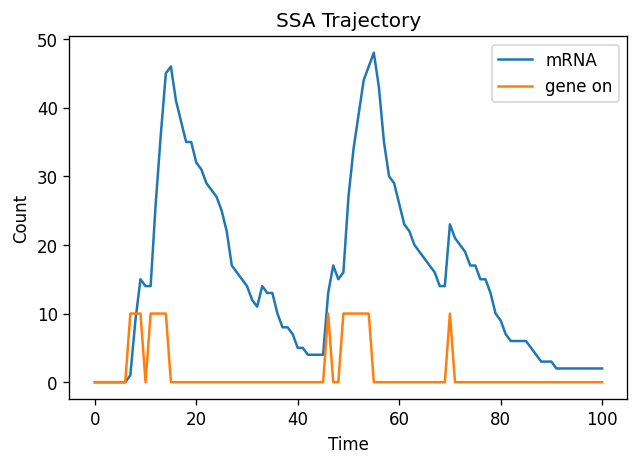

In [15]:
# Vector of Times
t = np.linspace(0, 100, 101) 

# Model Parameters (k_on, k_off, k_mrna, k_mrna_decay)
Pars = np.array([0.2,0.5,10,0.1])
k_on,k_off,k_R,gamma = Pars

# Vector of Initial Conditions (OFF,ON,R)
X = np.array([1,0,0], dtype=int)   # OFF = X[0], ON = X[1], R = X[2]  

# Stoichiometry Matrix -- must be transposed (flipped) 
# Species:    OFF,ON,mRNA
S = np.array([[-1, 1, 0],     # Rxn 1: OFF --> ON  
              [1, -1, 0],     # Rxn 2: ON --> OFF
              [0, 0, 1],      # Rxn 3: ON --> ON + mRNA  (mRNA synthesis)
              [0, 0, -1]]).T  # Rxn 4: mRNA --> phi  (mRNA decay)

# Propensity Functions (anonymous function)
W = lambda X: np.array([[k_on*X[0]],  # Pars[0]*X[0]
              [k_off*X[1]],           # Pars[1]*X[1]
              [k_R*X[1]],          # Pars[2]*X[1]
              [gamma*X[2]]]).T   # Pars[3]*X[2]
              
# Run the SSA for a single trajectory
off, on, mRNA = SSA_traj(S, W, X, t)

# Plot the counts from the SSA
plt.figure(dpi=120)
plt.plot(mRNA);
plt.plot(on*10); 
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('SSA Trajectory')
plt.legend(['mRNA', 'gene on'])

* **Q3)** Change the code below to add protein production and degradation to this model? Update the codes and make a plot of the trajectories for the number of active genes, the number of mRNA, and the number of protein.



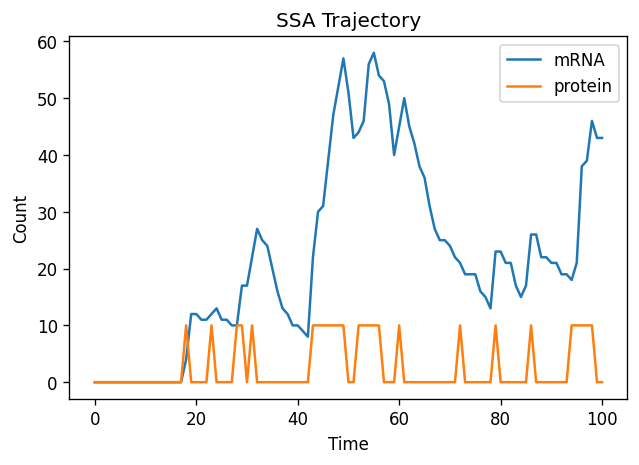

In [ ]:
# Vector of Times
t = np.linspace(0, 100, 101) 

# Model Parameters (k_on, k_off, k_mrna, k_mrna_decay)
Pars = np.array([0.2,0.5,10,0.1])
k_on,k_off,k_R,gamma = Pars

# Vector of Initial Conditions (OFF,ON,R)
X = np.array([1,0,0], dtype=int)   # OFF = X[0], ON = X[1], R = X[2]  

# Stoichiometry Matrix -- must be transposed (flipped) 
# Species:    OFF,ON,mRNA
S = np.array([[-1, 1, 0],     # Rxn 1: OFF --> ON  
              [1, -1, 0],     # Rxn 2: ON --> OFF
              [0, 0, 1],      # Rxn 3: ON --> ON + mRNA  (mRNA synthesis)
              [0, 0, -1]]).T  # Rxn 4: mRNA --> phi  (mRNA decay)

# Propensity Functions (anonymous function)
W = lambda X: np.array([[k_on*X[0]],  # Pars[0]*X[0]
              [k_off*X[1]],           # Pars[1]*X[1]
              [k_R*X[1]],          # Pars[2]*X[1]
              [gamma*X[2]]]).T   # Pars[3]*X[2]
              
# Run the SSA for a single trajectory
off, on, mRNA = SSA_traj(S, W, X, t)

# Plot the counts from the SSA
plt.figure(dpi=120)
plt.plot(mRNA);
plt.plot(on*10); 
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('SSA Trajectory')
plt.legend(['mRNA', 'protein'])

* __Q4__ Make another figure that shows the relative fluctuations (e.g., x(t)/mean(x)) for each of the number of active genes, the number of mRNA, and the number of protein.  Comment on how well this matches your what you expectated in Q1.  See if you can change the parameters so that the relative variation is about the same for all species.

In [ ]:
# Write your own code to make these figures.  You should reuse the data calculated from above.

# Medium Questions:



In [ ]:
#@markdown  * **Q5)** Given the state ($\mathbf{x}$) and a set of propensity functions $\mathbf{w}(\mathbf{x}$): 
#@markdown What is the probability mass function for the reaction numer of the next event?
#@markdown What is the probability density function for when the next reaction will occur?
#@markdown What is the probability that no reaction will occur before time $t$?  
#@markdown Adjust the code to calculate these answers.

W = lambda X: np.array([[k_on*X[0]],  # Pars[0]*X[0]
              [k_off*X[1]],           # Pars[1]*X[1]
              [k_R*X[1]],          # Pars[2]*X[1]
              [gamma*X[2]]]).T   # Pars[3]*X[2]

X = np.array([5,3,4], dtype=int)  

t = 1.4

PMF_n = np.array([1.,1.,1.,1.])  # Replace with code to calculated the PMF for the next reaction.

PDF_t = 0.34



*   **Q6)** Consider the bursting gene model from above. How could you adjust the parameters {k_on, k_off, k, and gamma} so that the average time between bursts is 2 minutes, the average burst lasts for 0.5 minutes, the average mRNA count during a burst is 20, and bursts decay with a half life of 0.25 minutes after turning off?  

In [ ]:
t_off = 2
t_on = 0.5
h_burst = 20.
tau_decay = 0.25
# Copy and adjust the bursting mRNA model to match these observations.  Make a figure that shows a long trajectory of ~30minutes


*   **Q7)** Write some code that create a graph to compare the average of 1000 SSA simulations to the solution of the matching the ODE analysis? Show that these are very similar when the propensity functions are all linear.

In [ ]:
# Write your code here to answer Q7



#More Involved Questions

**Q8)** Modify the stoichiometry matrix and propensity functions for the other example models provided. 

    - Example 1: Birth/Decay Model
    - Example 2: Genetic Toggle
    - Example 3: Stochastic Oscillator

-Run the SSA for each of these example models. How do the results differ from the 2-state bursting gene model? 

In [ ]:
##################### Example 1 #####################

# Model Parameters (k_on, k_off, k_mrna, k_mrna_decay)
Pars = np.array([0.2,0.5,10,0.1])
k_on,k_off,k_R,gamma = Pars

# Vector of Initial Conditions (OFF,ON,R)
X = np.array([1,0,0], dtype=int)   # OFF = X[0], ON = X[1], R = X[2]  

# Stoichiometry Matrix -- must be transposed (flipped) 
# Species:    OFF,ON,mRNA
S = np.array([[-1, 1, 0],     # Rxn 1: OFF --> ON  
              [1, -1, 0],     # Rxn 2: ON --> OFF
              [0, 0, 1],      # Rxn 3: ON --> ON + mRNA  (mRNA synthesis)
              [0, 0, -1]]).T  # Rxn 4: mRNA --> phi  (mRNA decay)

# Propensity Functions (anonymous function)
W = lambda X: np.array([[k_on*X[0]],  # Pars[0]*X[0]
              [k_off*X[1]],           # Pars[1]*X[1]
              [k_R*X[1]],          # Pars[2]*X[1]
              [gamma*X[2]]]).T   # Pars[3]*X[2]
              
# Run the SSA for a single trajectory
off, on, mRNA = SSA_traj(S, W, X, t)

# Plot the counts from the SSA
plt.figure(dpi=120)
plt.plot(mRNA);
plt.plot(on*10); 
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('SSA Trajectory')
plt.legend(['mRNA', 'protein'])

TypeError: ignored

In [ ]:
##################### Example 2 #####################

# Model Parameters (k_on, k_off, k_mrna, k_mrna_decay)
Pars = np.array([0.2,0.5,10,0.1])
k_on,k_off,k_R,gamma = Pars

# Vector of Initial Conditions (OFF,ON,R)
X = np.array([1,0,0], dtype=int)   # OFF = X[0], ON = X[1], R = X[2]  

# Stoichiometry Matrix -- must be transposed (flipped) 
# Species:    OFF,ON,mRNA
S = np.array([[-1, 1, 0],     # Rxn 1: OFF --> ON  
              [1, -1, 0],     # Rxn 2: ON --> OFF
              [0, 0, 1],      # Rxn 3: ON --> ON + mRNA  (mRNA synthesis)
              [0, 0, -1]]).T  # Rxn 4: mRNA --> phi  (mRNA decay)

# Propensity Functions (anonymous function)
W = lambda X: np.array([[k_on*X[0]],  # Pars[0]*X[0]
              [k_off*X[1]],           # Pars[1]*X[1]
              [k_R*X[1]],          # Pars[2]*X[1]
              [gamma*X[2]]]).T   # Pars[3]*X[2]
              
# Run the SSA for a single trajectory
off, on, mRNA = SSA_traj(S, W, X, t)

# Plot the counts from the SSA
plt.figure(dpi=120)
plt.plot(mRNA);
plt.plot(on*10); 
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('SSA Trajectory')
plt.legend(['mRNA', 'protein'])

In [ ]:
##################### Example 3 #####################

# Model Parameters (k_on, k_off, k_mrna, k_mrna_decay)
Pars = np.array([0.2,0.5,10,0.1])
k_on,k_off,k_R,gamma = Pars

# Vector of Initial Conditions (OFF,ON,R)
X = np.array([1,0,0], dtype=int)   # OFF = X[0], ON = X[1], R = X[2]  

# Stoichiometry Matrix -- must be transposed (flipped) 
# Species:    OFF,ON,mRNA
S = np.array([[-1, 1, 0],     # Rxn 1: OFF --> ON  
              [1, -1, 0],     # Rxn 2: ON --> OFF
              [0, 0, 1],      # Rxn 3: ON --> ON + mRNA  (mRNA synthesis)
              [0, 0, -1]]).T  # Rxn 4: mRNA --> phi  (mRNA decay)

# Propensity Functions (anonymous function)
W = lambda X: np.array([[k_on*X[0]],  # Pars[0]*X[0]
              [k_off*X[1]],           # Pars[1]*X[1]
              [k_R*X[1]],          # Pars[2]*X[1]
              [gamma*X[2]]]).T   # Pars[3]*X[2]
              
# Run the SSA for a single trajectory
off, on, mRNA = SSA_traj(S, W, X, t)

# Plot the counts from the SSA
plt.figure(dpi=120)
plt.plot(mRNA);
plt.plot(on*10); 
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('SSA Trajectory')
plt.legend(['mRNA', 'protein'])

- **Q9)** In linear models, the mean level behavior is the exact same as the deterministic model but this isn't true for non-linear models. What would happen in the cases where the propensity function is concave/convex? Write your answer below in the text box.

In [ ]:
 #@markdown Write a code to formulate and simulate a one species stochastic system with a convex (e.g., $k*x^2/(M+x)$) production rate propensity function and one with a convex propensity function (e.g., $k*\sqrt{x}$) production rate propensity function. Plot the average of multiple SSA trajectories of both cases on separate graphs and compare each to its ODE approximation.  Try different values for $k$ and $M$ and comment on the differences between the SSA mean and the ODE. 
